In [ ]:
import pandas as pd

df_sales = pd.read_csv("data\Online_Sales.csv")
df_discount = pd.read_csv("data\Discount_Coupon.csv")
df_tax = pd.read_csv("data\Tax_amount.xlsx")

# Performing Customer Segmentation

### Heuristic (Value based, RFM)

In [ ]:
df_sales['Transaction_Date'] = pd.to_datetime(df_sales['Transaction_Date'], format='%m/%d/%Y')
df_sales['Month'] = df_sales['Transaction_Date'].dt.strftime('%b')


In [ ]:
df_aux1 = df_sales.drop(columns=["CustomerID", "Product_SKU", "Product_Description"])
result = pd.merge(df_aux1, df_discount, on=['Month', 'Product_Category'], how='left')
merged_df = pd.merge(result,df_tax,on=['Product_Category'], how = 'left')


In [ ]:
merged_df["Coupon_Code"].fillna("NoCupon", inplace=True)
merged_df["Discount_pct"].fillna(0, inplace=True)


In [ ]:
merged_df['Revenue'] = np.where(
    merged_df['Coupon_Status'] == 'Used',
    ((merged_df['Quantity'] * merged_df['Avg_Price']) * (1 - merged_df['Discount_pct']/100) * (1 + merged_df['GST'])) + merged_df['Delivery_Charges'],
    ((merged_df['Quantity'] * merged_df['Avg_Price']) * (1 + merged_df['GST'])) + merged_df['Delivery_Charges']
)


In [ ]:
df_sales["Revenue"] = merged_df["Revenue"]

In [ ]:
today = pd.to_datetime('2020-01-01')  # Replace with the current date
segment = df_sales.groupby('CustomerID').agg({
    'Transaction_Date': lambda x: (today - x.max()).days,  # Calculate recency
    'Transaction_ID': 'count',  # Calculate frequency
    'Revenue': 'sum'  # Calculate monetary value
})

In [ ]:
segment

,Transaction_Date,Transaction_ID,Revenue
CustomerID,,,
12346,108,2,174.98174
12347,60,60,15686.84396
12348,74,23,1689.55594
12350,18,17,1467.43528
12356,108,36,2007.42900
...,...,...,...
18259,271,7,860.68600
18260,88,40,3016.54372
18269,195,8,166.90750


In [ ]:
# Definir R F M thresholds
r_thresholds = [0, 100, 200, 300, float('inf')]  
f_thresholds = [0, 40, 70, 100, float('inf')]  
m_thresholds = [0, 4000, 7000,10000, float('inf')]  

#creamos columnas para con cada uno de las caracteristicas
segment['R_Segment'] = pd.cut(segment['Transaction_Date'], bins=r_thresholds, labels=False) + 1
segment['F_Segment'] = pd.cut(segment['Transaction_ID'], bins=f_thresholds, labels=False) + 1
segment['M_Segment'] = pd.cut(segment['Revenue'], bins=m_thresholds, labels=False) + 1


# creamos una columna nueva para asignar valores y hacer la segmentacion
segment['RFM_Segment'] = segment['R_Segment'] * 10 + segment['F_Segment'] * 10 + segment['M_Segment']*10


def h_segmentation(RFM_Segment):
  if RFM_Segment<=40:
    return 'Standard'
  elif (RFM_Segment>40) & (RFM_Segment<=70):
    return 'Silver'
  elif (RFM_Segment>70) & (RFM_Segment<=90):
    return 'Premium'
  else:
    return 'Gold'


segment['heuristic_segment'] = segment['RFM_Segment'].apply(h_segmentation)

In [ ]:
segment

,Transaction_Date,Transaction_ID,Revenue,R_Segment,F_Segment,M_Segment,RFM_Segment,heuristic_segment
CustomerID,,,,,,,,
12346,108,2,174.98174,2,1,1,40,Standard
12347,60,60,15686.84396,1,2,4,70,Silver
12348,74,23,1689.55594,1,1,1,30,Standard
12350,18,17,1467.43528,1,1,1,30,Standard
12356,108,36,2007.42900,2,1,1,40,Standard
...,...,...,...,...,...,...,...,...
18259,271,7,860.68600,3,1,1,50,Silver
18260,88,40,3016.54372,1,1,1,30,Standard
18269,195,8,166.90750,2,1,1,40,Standard


### Scientific (Using K-Means)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
features = segment[['Transaction_Date', 'Transaction_ID', 'Revenue']]

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Choose the number of clusters (K)
k = 4

# Apply K-Means clustering
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
segment['kmean_segment'] = kmeans.fit_predict(scaled_features)

segment.head()

,Transaction_Date,Transaction_ID,Revenue,R_Segment,F_Segment,M_Segment,RFM_Segment,heuristic_segment,kmean_segment_label,kmean_segment
CustomerID,,,,,,,,,,
12346,108,2,174.98174,2,1,1,40,Standard,Standar,0
12347,60,60,15686.84396,1,2,4,70,Silver,Gold,2
12348,74,23,1689.55594,1,1,1,30,Standard,Standar,0
12350,18,17,1467.43528,1,1,1,30,Standard,Standar,0
12356,108,36,2007.42900,2,1,1,40,Standard,Standar,0


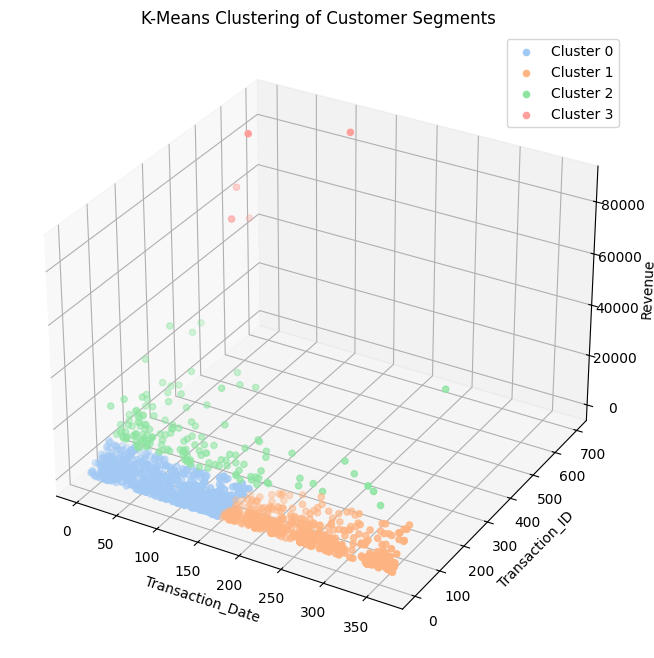

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Plotting the clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for each cluster
for cluster_label in range(k):
    cluster_data = segment[segment['kmean_segment'] == cluster_label]
    ax.scatter(cluster_data['Transaction_Date'], cluster_data['Transaction_ID'], cluster_data['Revenue'], label=f'Cluster {cluster_label}')

# Adding labels
ax.set_xlabel('Transaction_Date')
ax.set_ylabel('Transaction_ID')
ax.set_zlabel('Revenue')
ax.set_title('K-Means Clustering of Customer Segments')

# Adding a legend
ax.legend()

# Show the plot
plt.show()

In [ ]:
def label_clusters(cluster):
    if cluster == 0:
        return 'Standar'
    elif cluster == 1:
        return 'Silver'
    elif cluster == 2:
        return 'Gold'
    else:
        return 'Premium'

# Apply the label_clusters function to assign labels
segment['kmean_segment_label'] = segment['kmean_segment'].apply(label_clusters)
segment.drop(columns='kmean_segment',inplace=True)

In [ ]:
segment.to_csv("segmentation.csv")

### Predicting Customer Lifetime Value (Low Value/Medium Value/High Value)

In [ ]:
segment['Value_Category'] = pd.cut(segment['Revenue'], bins=[0, 1000, 5000, float('inf')],
                              labels=['Low Value', 'Medium Value', 'High Value'])

In [ ]:
segment

,Transaction_Date,Transaction_ID,Revenue,R_Segment,F_Segment,M_Segment,RFM_Segment,heuristic_segment,kmean_segment_label,Value_Category
CustomerID,,,,,,,,,,
12346,108,2,174.98174,2,1,1,40,Standard,Standar,Low Value
12347,60,60,15686.84396,1,2,4,70,Silver,Gold,High Value
12348,74,23,1689.55594,1,1,1,30,Standard,Standar,Medium Value
12350,18,17,1467.43528,1,1,1,30,Standard,Standar,Medium Value
12356,108,36,2007.42900,2,1,1,40,Standard,Standar,Medium Value
...,...,...,...,...,...,...,...,...,...,...
18259,271,7,860.68600,3,1,1,50,Silver,Silver,Low Value
18260,88,40,3016.54372,1,1,1,30,Standard,Standar,Medium Value
18269,195,8,166.90750,2,1,1,40,Standard,Silver,Low Value


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

# Selecting features and target variable
X = segment[['Transaction_Date', 'Transaction_ID', 'Revenue', 'R_Segment', 'F_Segment', 'M_Segment']]
y = segment['Value_Category']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Decision Tree Classifier
clf = DecisionTreeClassifier()

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the testing set
predictions = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, predictions))
print("Classification Report:\n", classification_report(y_test, predictions))

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

  High Value       1.00      1.00      1.00        60
   Low Value       1.00      1.00      1.00        85
Medium Value       1.00      1.00      1.00       149

    accuracy                           1.00       294
   macro avg       1.00      1.00      1.00       294
weighted avg       1.00      1.00      1.00       294

